In [3]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import scipy.io as spio
from LLR import LLR
import matplotlib.pyplot as plt

import math

n_ch = 13
h_ch = np.load(f'H6Length{n_ch}.npy')
ch_len = 5
h_sp = h_ch[ch_len//2][0:ch_len] 

h = np.zeros((ch_len,ch_len))

for i in range(ch_len//2+1):
    h[i][:ch_len//2 + i + 1] = h_sp[ch_len//2 - i:]
for i in range(ch_len//2+1):
    h[ch_len//2+i] = h[ch_len//2-i][::-1]
np.round(h,3)

array([[ 0.849,  0.344, -0.142,  0.   ,  0.   ],
       [ 0.344,  0.849,  0.344, -0.142,  0.   ],
       [-0.142,  0.344,  0.849,  0.344, -0.142],
       [ 0.   , -0.142,  0.344,  0.849,  0.344],
       [ 0.   ,  0.   , -0.142,  0.344,  0.849]])

In [3]:
class cluster:
    def __init__(self,n_tran=17):
        self.n_tran = n_tran
        self.mid_tran = self.n_tran//2
        self.trun_len = 5
        self.mid_trun = self.trun_len//2
        self.llrVal = []
    
    def fitModel(self,neigh=1):
        pos = []
        neg = []
        # cnt = 0
        points = set()
        X = []
        Y = []
        self.s_in = []
        for i in range(2**self.n_tran):
            temp = 0
            sig = []
            for j in range(self.n_tran):
                if (i&(2**j)) != 0:
                    sig += [1]
                else: 
                    sig += [-1]
            o = []
            Y += [sig[self.mid_tran]]
            for j in range(self.mid_trun,self.n_tran - self.mid_trun):
                o += [np.round(np.dot(sig[j-self.mid_trun:j+self.mid_trun+1],h_sp),4)]
            X += [o]
            self.s_in += [sig[self.mid_trun:self.n_tran-self.mid_trun]]
            points.add(tuple(o)) 
            
            temp = np.round(temp,4)
        

        print("number of cluster points:", len(points))
        self.X_train = np.array(X)
        self.Y_train = np.array(Y)
        pos = np.unique(pos)
        neg = np.unique(neg)
        print(*pos)
        # print(cnt)
        print("-*******-")
        print(*neg)
        self.s_in = np.array(self.s_in)
        
        print('cluster points shape',self.X_train.shape)
        self.model = KNeighborsClassifier(n_neighbors=neigh,weights='distance').fit(self.X_train,self.Y_train)
        # self.model = GaussianNB().fit(X,Y)
        print('error in training:', sum(self.model.predict(self.X_train) != self.Y_train))
        return self.model

    def reduced_model(self):
        
        return
    
    

    def testModelLLR(self,ebno,data):
        noisePw = 1/(10**(ebno/10))
        dim = self.n_tran - self.trun_len + 1
        print(dim)
        self.llrVal = []
        for step in range(0,len(data),n_ch):
            print(step)
            s = 2*data[step:step+n_ch]-1
            s = np.array(s).reshape((n_ch, 1))
            noise = np.sqrt(noisePw/2)*np.random.standard_normal((n_ch,1))
            r = np.dot(h_ch,s) + noise
            X_t = np.zeros((n_ch-(dim-1),dim))
            Y = []
            for i in range(dim//2,n_ch-dim//2):
                for idx,val in enumerate(r[i-dim//2:i+dim//2+1]):
                    X_t[i-dim//2][idx] = np.round(val,4)
                Y += [1 if s[i] > 0 else -1]
            Y = np.array(Y)
            # Y_t = self.model.predict(X_t)
            
            self.X_test = X_t
            Y_t = self.model.kneighbors(self.X_test)
            
#             self.llrVal += [20.0,20.0]
            for j in range(len(Y_t[0])):
                candList = []
                for idx in Y_t[1][j]:
                    candList += [self.s_in[idx].T]
                outputLLR = LLR(n = dim, candList = candList, noisePw=noisePw, dis=Y_t[0][j])
                
                if j == 0: self.llrVal += outputLLR[0][:dim//2+1]
                elif j == len(Y_t[0]) - 1: self.llrVal += [outputLLR[0][dim//2:]]
                else: self.llrVal += [outputLLR[dim//2]]
                
                print(j,len(Y_t[0]),len(self.llrVal),self.llrVal)
            
        return self.llrVal

    def testModel(self,ebno,num_iteration):
        noisePw = 1/(10**(ebno/10))
        dim = self.n_tran - self.trun_len + 1
        err = []
        for _ in range(num_iteration):
            print(_)
            s = 2*np.random.randint(2,size=(n_ch,1))-1
            noise = np.sqrt(noisePw/2)*np.random.standard_normal((n_ch,1))
            r = np.dot(h_ch,s) + noise
            X_t = np.zeros((n_ch-(self.n_tran-1),dim))
            Y = []
            for i in range(self.mid_tran,n_ch-self.mid_tran):
                for id,val in enumerate(r[i-dim//2:i+dim//2+1]):
                    X_t[i-self.mid_tran][id] = np.round(val,4)
                Y += [1 if s[i] > 0 else -1]
            Y = np.array(Y)
            
            Y_t = self.model.predict(X_t)
            err += [sum(Y_t != Y)/len(Y)]
        print(np.mean(err))
        return np.mean(err)


In [12]:

sysModel = cluster(n_tran = 11)
sysModel.fitModel(neigh=8)


number of cluster points: 2048

-*******-

cluster points shape (2048, 7)
error in training: 0


KNeighborsClassifier(n_neighbors=8, weights='distance')

In [31]:
def min_dist(X,Y):
    X1 = []
    X2 = []
    X = X.tolist()
    mdist = 100
    for x,y in zip(X,Y):
        if y > 0: X1 += [x]
        else: X2 += [x]
    X1 = np.array(X1)
    X2 = np.array(X2)
    for x1 in X1:
        for x2 in X2:
            # print(x1-x2)
            # exit()
            mdist = min(mdist,np.sqrt(sum([i**2 for i in x1-x2])))
    print(mdist)
    return mdist
arr = []
# for i in range(15,2):
sysModel = cluster(n_tran = 9)
sysModel.fitModel(neigh=8)
min_dist(sysModel.X_train,sysModel.Y_train)


number of cluster points: 512

-*******-

cluster points shape (512, 5)
error in training: 0
0.4249973411681537


0.4249973411681537

In [2]:
# neb = 32
# sysModel = cluster(n_tran = 21)
# sysModel.fitModel(neigh=neb)
# temp =  sysModel.model.kneighbors(sysModel.X_train)
# ids = temp[1]
# dist = temp[0]
# mn = 100
# for id,dis in zip(ids,dist):
#     for j in range(1,neb):
#         if sysModel.Y_train[id[j]] != sysModel.Y_train[id[0]]:
#             mn = min(mn,dis[j])
# #     break
# print('minimum distance (reduced oredr)', mn)

##
# 13 = 0.808574461629849
# 15 = 0.8786837542597451


SyntaxError: invalid character in identifier (818506283.py, line 24)

In [18]:
# temp =  sysModel.model.kneighbors(sysModel.X_train)
# ids = temp[1]
# dist = temp[0]
# print(sysModel.X_train[0])
# print(ids[0])
# print(dist[0])
# print(np.sqrt(sum((sysModel.X_train[0] - sysModel.X_train[256])**2)))

[-1.2526 -1.2526 -1.2526 -1.2526 -1.2526]
[  0   1 256 257   3 384 259 385]
[0.         0.2832     0.2832     0.40050528 0.49329246 0.49329246
 0.56880549 0.56880549]
0.2832000000000001


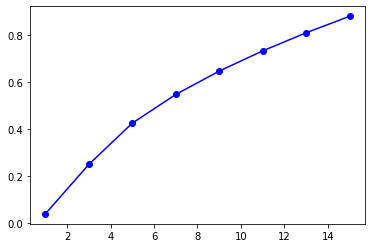

In [7]:
arr=[ 0.039900000000000005,0.2496602891931354,0.4249973411681537,
        0.5467313965742228,0.6459161710315048,0.7317787780470271,0.808574461629849,0.8786837542597451]
plt.plot([1,3,5,7,9,11,13,15],arr,'bo-')

In [24]:
arr

[0.039900000000000005,
 0.2496602891931354,
 0.4249973411681537,
 0.5467313965742228,
 0.6459161710315048]

In [4]:
mat = spio.loadmat('./data/testData13e5_int.mat')
dataIn = np.array(mat['intrl'],dtype=int)[0]
print(len(dataIn))

2600000


In [10]:

ebno = 8
codeRate = 0.5
snr = ebno + 10*math.log10(codeRate)
print("snr",snr)
noisePw = 1/(10**(snr/10))
dim = sysModel.n_tran - sysModel.trun_len + 1
print(dim)
llrVal = []
err = []
for step in range(0,len(dataIn),n_ch):
    if step % 1300 == 0 : print(step)
    s = 2*dataIn[step:step+n_ch]-1
    s = np.array(s).reshape((n_ch, 1))
    total_energy = sum([ii**2 for ii in s])
    energyPerSym = total_energy / n_ch
    noise = np.sqrt(noisePw/2)*np.random.standard_normal((n_ch,1))
    
    r = np.dot(h_ch,s) + noise
    X_t = np.zeros((n_ch-(dim-1),dim))
    Y = []
    for i in range(dim//2,n_ch-dim//2):
        for idx,val in enumerate(r[i-dim//2:i+dim//2+1]):
            X_t[i-dim//2][idx] = np.round(val,4)
        Y += [1 if s[i] > 0 else -1]
    Y = np.array(Y)
    # Y_t = self.model.predict(X_t)

    X_test = X_t
    Y_t = sysModel.model.kneighbors(X_test)
    
    Y_tt = sysModel.model.predict(X_t)
    err += [sum(Y_tt != Y)/len(Y)]
    
    
    
    for j in range(len(Y_t[0])):
        candList = []
        for idx in Y_t[1][j]:
            candList += [sysModel.s_in[idx].T]
        outputLLR = LLR(n = dim, candList = candList, noisePw=noisePw, dis=Y_t[0][j])
        llrVal += list(outputLLR)
#         if j == 0: llrVal += list(outputLLR[:dim//2+1])
#         elif j == len(Y_t[0]) - 1: llrVal += list(outputLLR[dim//2:])
#         else: llrVal += [outputLLR[dim//2]]
#     print(llrVal)
#     break
print(np.mean(err))
    
print(len(llrVal))

snr 4.9897000433601875
13
0
1300
2600
3900
5200
6500
7800
9100
10400
11700
13000
14300
15600
16900
18200
19500
20800
22100
23400
24700
26000
27300
28600
29900
31200
32500
33800
35100
36400
37700
39000
40300
41600
42900
44200
45500
46800
48100
49400
50700
52000
53300
54600
55900
57200
58500
59800
61100
62400
63700
65000
66300
67600
68900
70200
71500
72800
74100
75400
76700
78000
79300
80600
81900
83200
84500
85800
87100
88400
89700
91000
92300
93600
94900
96200
97500
98800
100100
101400
102700
104000
105300
106600
107900
109200
110500
111800
113100
114400
115700
117000
118300
119600
120900
122200
123500
124800
126100
127400
128700
130000
131300
132600
133900
135200
136500
137800
139100
140400
141700
143000
144300
145600
146900
148200
149500
150800
152100
153400
154700
156000
157300
158600
159900
161200
162500
163800
165100
166400
167700
169000
170300
171600
172900
174200
175500
176800
178100
179400
180700
182000
183300
184600
185900
187200
188500
189800
191100
192400
193700
195000
19630

1467700
1469000
1470300
1471600
1472900
1474200
1475500
1476800
1478100
1479400
1480700
1482000
1483300
1484600
1485900
1487200
1488500
1489800
1491100
1492400
1493700
1495000
1496300
1497600
1498900
1500200
1501500
1502800
1504100
1505400
1506700
1508000
1509300
1510600
1511900
1513200
1514500
1515800
1517100
1518400
1519700
1521000
1522300
1523600
1524900
1526200
1527500
1528800
1530100
1531400
1532700
1534000
1535300
1536600
1537900
1539200
1540500
1541800
1543100
1544400
1545700
1547000
1548300
1549600
1550900
1552200
1553500
1554800
1556100
1557400
1558700
1560000
1561300
1562600
1563900
1565200
1566500
1567800
1569100
1570400
1571700
1573000
1574300
1575600
1576900
1578200
1579500
1580800
1582100
1583400
1584700
1586000
1587300
1588600
1589900
1591200
1592500
1593800
1595100
1596400
1597700
1599000
1600300
1601600
1602900
1604200
1605500
1606800
1608100
1609400
1610700
1612000
1613300
1614600
1615900
1617200
1618500
1619800
1621100
1622400
1623700
1625000
1626300
1627600
1628900


In [11]:
import csv
fields = []
for i in llrVal:
    fields += [float(i)]
with open('./data/LLR13verf'+str(ebno)+'db.csv', mode='w') as csv_file:
    writer = csv.writer(csv_file, delimiter='\n', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(fields)

In [ ]:
# [ 0.1166, 0.0046, 4.0003e-06]
# [0.3818, 0.1363, 0.0059, 8.0054e-05]

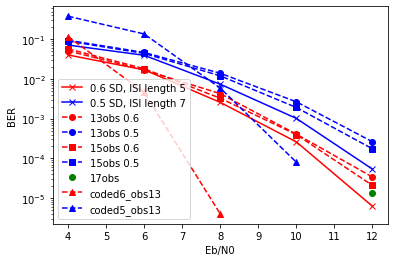

In [1]:




rng = range(4,13,2)

uncoded6_SD = [0.0404, 0.017024793388429754, 0.002578268876611418, 0.00026040995230114736,6.23058782e-06]
uncoded5_SD = [0.07172414, 0.03961905, 0.00739927, 0.00101771, 5.36256457e-05]



# 13 obs
obs13_6=[0.051219512195121955,0.016880081300813005,0.004278455284552845,0.0004085365853658537,3.397148676171079e-05]
obs13_5=[0.09470468431771893,0.04675152749490835,0.013951120162932791,0.0026680244399185336,0.00026272912423625254]

# 15 obs
obs15_6=[0.057433808553971476,0.018228105906313647,0.0032790224032586564,0.0003971486761710794,2.0875763747454175e-05]
obs15_5=[0.09010204081632653,0.04408163265306122,0.012030612244897957,0.0019183673469387757,0.00017448979591836735]


coded6_LSD = [0.0403,0.0067,4.5627e-04,1.7501e-05]
coded6_obs13 = [0.1166, 0.0046, 4.0003e-06]
coded5_obs13 = [0.3818, 0.1363, 0.0059, 8.0054e-05]
plt.yscale("log")
plt.xlabel("Eb/N0")
plt.ylabel("BER")
plt.plot(rng,uncoded6_SD,'rx-')
plt.plot(rng,uncoded5_SD,'bx-')
plt.plot(rng,obs13_6,'ro--')
plt.plot(rng,obs13_5,'bo--')
plt.plot(rng,obs15_6,'rs--')
plt.plot(rng,obs15_5,'bs--')
plt.plot([12],1.3775510204081633e-05,'go')

plt.plot([4,6,8], coded6_obs13, 'r^--')
plt.plot([4,6,8,10], coded5_obs13, 'b^--')

plt.legend(['0.6 SD, ISI length 5','0.5 SD, ISI length 7',
            '13obs 0.6','13obs 0.5',
            '15obs 0.6','15obs 0.5','17obs','coded6_obs13','coded5_obs13'])
plt.show()


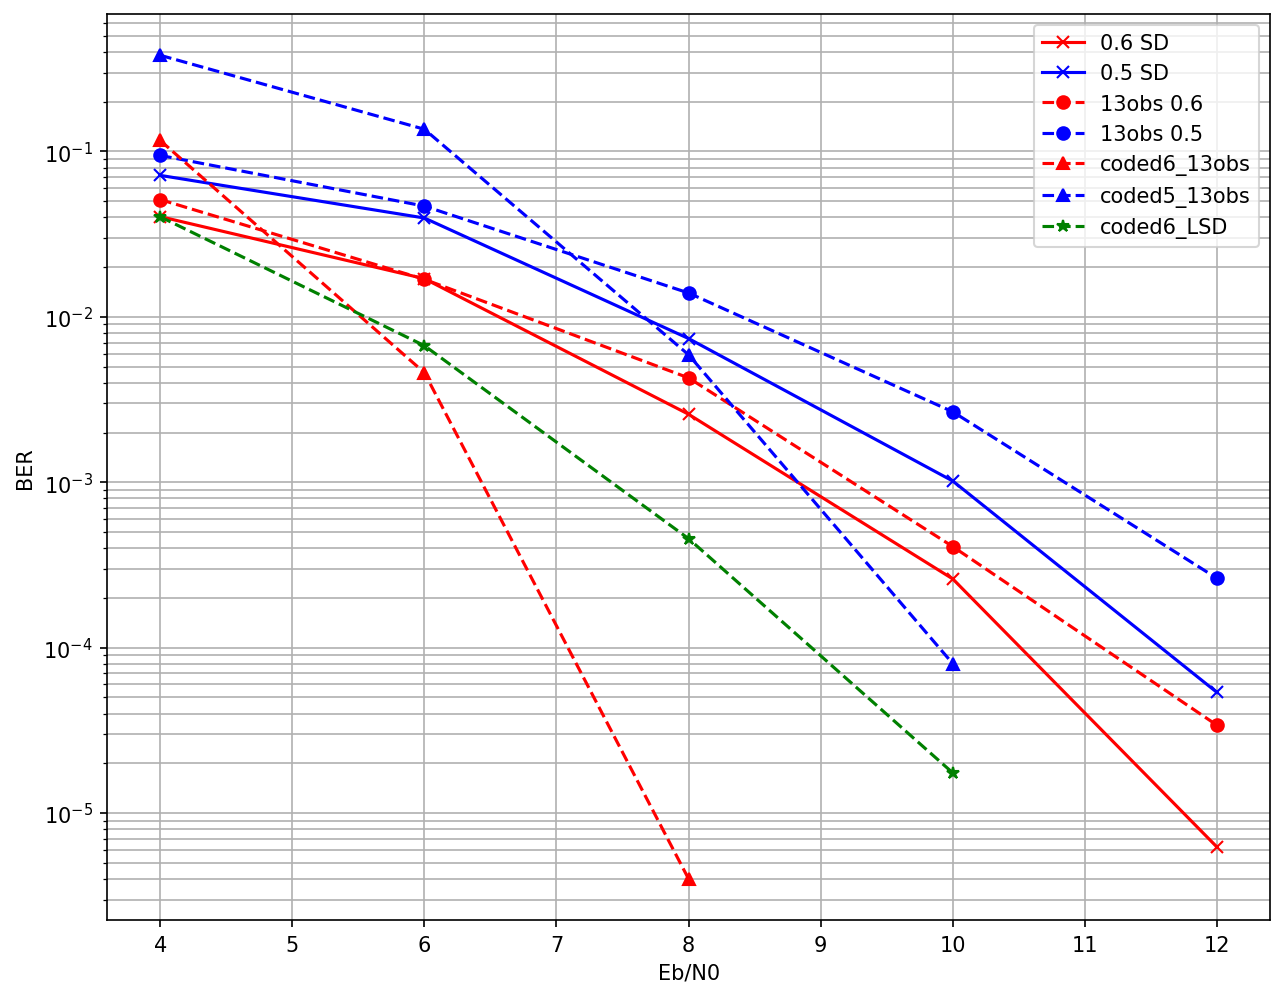

In [2]:

plt.figure(figsize=(10,8),dpi=150)
plt.plot(rng,uncoded6_SD,'rx-')
plt.plot(rng,uncoded5_SD,'bx-')
plt.plot(rng,obs13_6,'ro--')
plt.plot(rng,obs13_5,'bo--')
plt.plot([4,6,8], coded6_obs13, 'r^--')
plt.plot([4,6,8,10], coded5_obs13, 'b^--')
plt.plot([4,6,8,10], coded6_LSD, 'g*--')

plt.grid(True, which="both", ls="-")
plt.yscale("log")
plt.xlabel("Eb/N0")
plt.ylabel("BER")
plt.legend(['0.6 SD','0.5 SD',
            '13obs 0.6','13obs 0.5','coded6_13obs','coded5_13obs','coded6_LSD'])
plt.show()

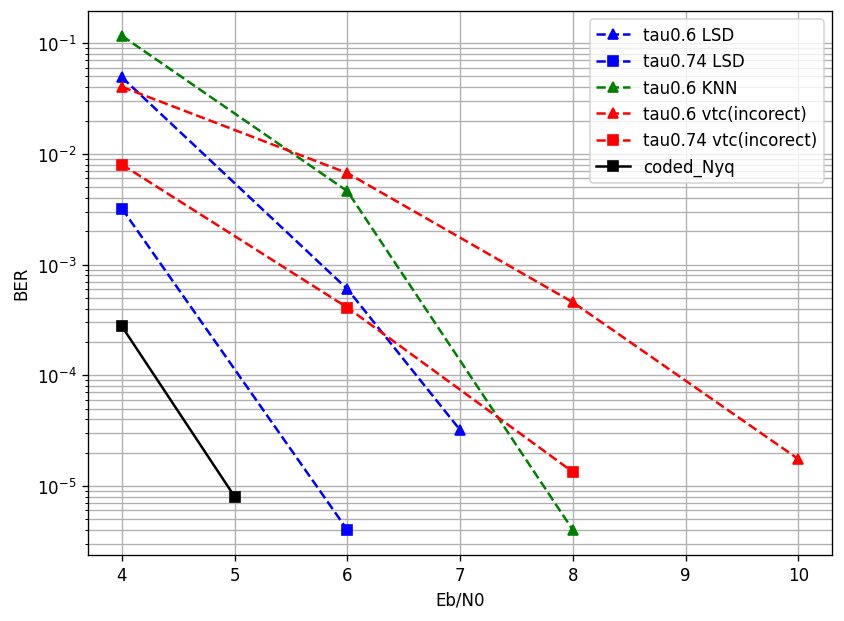

In [3]:
coded6_LSD = [0.0491,6.0041e-04,3.2002e-05]
coded74_LSD = [0.0032,4.0003e-06]
coded6_KNN = [0.1166, 0.0046, 4.0003e-06]
coded5_KNN = [0.3818, 0.1363, 0.0059, 8.0054e-05]
coded6_vtc = [0.0403,0.0067,4.5627e-04,1.7501e-05]
coded74_vtc = [0.0080, 4.0877e-04,1.3375e-05]
coded_Nyq = [2.7602e-04, 8.0005e-06]

plt.figure(figsize=(8,6),dpi=120)
plt.plot([4,6,7],coded6_LSD,'b^--')
plt.plot([4,6],coded74_LSD,'bs--')
plt.plot([4,6,8],coded6_KNN,'g^--')
plt.plot([4,6,8,10],coded6_vtc,'r^--')
plt.plot([4,6,8],coded74_vtc,'rs--')
plt.plot([4,5],coded_Nyq,'ks-')

# plt.plot([4,6,8],coded6_LSD,'rs--')

plt.grid(True, which="both", ls="-")
plt.yscale("log")
plt.xlabel("Eb/N0")
plt.ylabel("BER")
plt.legend(['tau0.6 LSD','tau0.74 LSD', 'tau0.6 KNN','tau0.6 vtc(incorect)','tau0.74 vtc(incorect)','coded_Nyq'])
plt.show()
